STUDENT: JOAN ROSSELLO BOVER

# Practical 7 - Part 1B
It's time to build something cool! One nice application of homographies is building a simple image stitcher for making panoramas. 

You'll reuse the routines you've written in part 1A (`calcBestHomography` and `solveAXEqualsZero`) again here, so feel free to copy over your functions directly. 

We're provided with three images. One large image, `im1`, is the target, i.e. we'll somehow transform and transfer two other images, `im2` and `im3` into this one.

We need some way of knowing how `im2` and `im3` map into `im1`. To that end, we'll assume a user (or a feature matching alogorithm) provided us with a sets of paired points. One set links points in `im1` to points in `im2`. The other set links `im1` and `im3` in the same manner. To perform the stitch, we'll find two homographies using these point pairs, one to translate between the space in `im1` and the space in `im2` and the other for `im1` and `im3`. 

The end result is worth it, so don't dispair!

## Import libraries 

In [28]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import time

## Loading and plotting images 

Red points show how `im2` and `im1` are related. Magenta points explain how `im1` and `im3` are related.

__NOTE:__ Before you get caught out, notice that the point pairs are in X, Y format, not in R, C format. In this convention, X points run along columns from left to right and Y points run along rows from top to bottom.

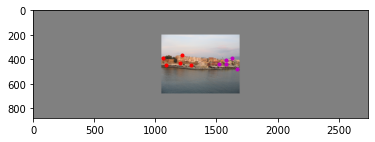

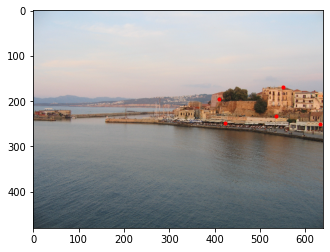

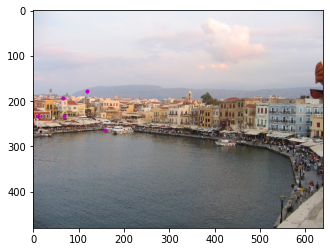

In [29]:
# Load data
data = sio.loadmat('PracticalData.mat', squeeze_me = True)
# Unpack data

# im1 is center image with grey background. im1 has enough space to insert im2 and im3.
im1 = data['im1']

# im2 is left image 
im2 = data['im2']

# pts1 and pts2 are matching points between image1 and image2
pts1 = data['pts1']
pts2 = data['pts2']


# im3 is right image
im3 = data['im3']
# pts1b and pts3 are matching points between image 1 and image 3
pts1b = data['pts1b']
pts3 = data['pts3']

# Show images and points
plt.imshow(im1)
plt.plot(pts1[0,:],pts1[1,:],'r.')
plt.plot(pts1b[0,:],pts1b[1,:],'m.')
plt.axis('off')
plt.show()

plt.imshow(im2)
plt.plot(pts2[0,:],pts2[1,:],'r.')
plt.axis('off')
plt.show()

plt.imshow(im3)
plt.plot(pts3[0,:],pts3[1,:],'m.')
plt.axis('off')
plt.show()

We have three images of the same scene where the camera has rotarted about the optical centre but not translated, and we have identified by hand five matching points between each pair (left image with central image, and right image with central image). These images are all related by homographies. Hence, it is possible to mat them all into one large image (image mosaicing).

## You should copy paste these functions from 1A. Half the work done! 

In [30]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 

    _, _, Vt = np.linalg.svd(A, full_matrices=True)
    V = np.transpose(Vt)
    h = V[:,-1].reshape((A.shape[-1],1)) # h0

    return h

In [31]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    # H = np.identity(3) ??? - not necessary

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = np.zeros([n_points * 2, 9])

    x = pts2Hom[0,:]
    y = pts2Hom[1,:]
    u = pts1Hom[0,:]
    v = pts1Hom[1,:]

    for i in range(n_points):

        A[2*i,:] = np.array([[0, 0, 0, -u[i], -v[i], -1, y[i]*u[i], y[i]*v[i], y[i]]])
        A[2*i+1,:] = np.array([[u[i], v[i], 1, 0, 0, 0, -x[i]*u[i], -x[i]*v[i], -x[i]]])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h, (3,3))
    
    return H

## The Process

Let's consider the first stitch, transforming and pasting `im2` into `im1`. 

We can loop over every location in `im1` and look in `im2` to see if there's a value we can paste in our image. The act of _looking_ into `im2` means that we need to translate from a location in `im1` to a location in `im2`. You can visualize this easily with the point correspondances already provided. For any other point in `im1`, we need a homography! You can use the function you've written before to generate this homography using `pts1` and `pts2`.

So now that we have a way of going from any location in `im1` to `im2`, we can loop over the locations in `im1`, get the corresponding positions in `im2` using the homography, and copy over that pixel value at each location from `im2` to `im1`.

There's one caveat, it's not always true that a transformed location from `im1` will be a valid index in `im2`, so for every index we need to check if it lies in the bounds of `im2`.

Don't worry if your solution takes a while to run. For loops aren't efficient. It might take anywhere from a minute to three for each stitch. You can make this much faster, but don't worry about that right now. 

Again, careful of how you translate between X-Y and R-C in your code when indexing; you've been warned! 

In [32]:
# TO DO: Calculate homography from pts1 to pts2 
H1 = calcBestHomography(pts1, pts2)

startTime = time.perf_counter()
# TO DO: 
# For every pixel in image 1 (two loops):
    # Transform this pixel position with your homography to find where it is in the coordinates of image 2
    # Make sure you round the position using np.round since you'll use it as an index to a matrix.
    # If it the transformed position is within the boundary of image 2: 
    #       Copy pixel colour from image 2 pixel to current position in image 1 
    # Note that the image coordinates are x-y, the x-axis is left to right, and y-axis is top to bottom, 
    # and the origin is on the left top corner.

for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        x1 = j
        y1 = i
        pt1 = np.array([[x1, y1]]).T
        pt1Hom = np.concatenate((pt1, np.ones((1,pt1.shape[1]))), axis=0)
        pt2Hom_est = np.matmul(H1, pt1Hom)
        pt2_est = pt2Hom_est[0:2,:] / np.tile([pt2Hom_est[2,:]],(2,1))
        x2 = int(np.round(pt2_est[0,0]))
        y2 = int(np.round(pt2_est[1,0]))
        if 0 <= x2 < im2.shape[1] and 0 <= y2 < im2.shape[0]:
            im1[i,j,:] = im2[y2, x2, :]
        

print("Stitching image 2 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 2 to image 1 took: 81.91s


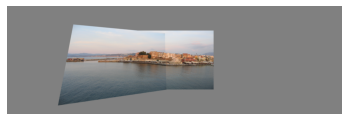

In [33]:
# Plot the intermediate panorama
plt.imshow(im1)
plt.axis('off')
plt.show()

First we find the homography that relates the central image with the left image using the 5 existing points we are given.

For every pixel in the central image, we convert that pixel location (i1,j1) to image coordinates (x1,y1) and apply the homography to the image coordinates of every piexl to obtain the corresponding image coordinates of every pixel in the left image (x2,y2). 

We check if the pixel coordinates are within the image dimensions, and if they are, then that means that that coordinate corresponds to a pixel in the image, so we assign the RGB values of the pixel (i2,j2) in the left image to the pixel (i1,j1) in the central image.

This way, we have merged the left image with the central image as if the left image and the central image had been taken together as one with the same camera orientation.

In the next step, we repeat the process with the right image and we blend it with the central image.

In [34]:
# TO DO: Repeat the above process mapping image 3 to image 1.

# Calculate homography from pts1b to pts3
H2 = calcBestHomography(pts1b, pts3)

startTime = time.perf_counter()
# loop and copy pixels...
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        x1 = j
        y1 = i
        pt1 = np.array([[x1, y1]]).T
        pt1Hom = np.concatenate((pt1, np.ones((1,pt1.shape[1]))), axis=0)
        pt3Hom_est = np.matmul(H2, pt1Hom)
        pt3_est = pt3Hom_est[0:2,:] / np.tile([pt3Hom_est[2,:]],(2,1))
        x3 = int(np.round(pt3_est[0,0]))
        y3 = int(np.round(pt3_est[1,0]))
        if 0 <= x3 < im3.shape[1] and 0 <= y3 < im3.shape[0]:
            im1[i,j,:] = im3[y3, x3, :]

print("Stitching image 3 to image 1 took: {0:.2f}s".format(time.perf_counter() - startTime))

Stitching image 3 to image 1 took: 74.87s


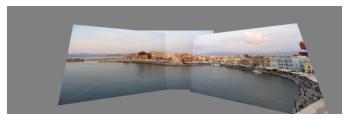

In [35]:
# Plot the final panorama
plt.imshow(im1)
plt.axis('off')
plt.show()

In the final result, we have the three images all together as one, as if the whole landscape was taken as one single picture (as if when we took the central picture with the respective camera orientation and position, the frame we could capture was much wider and the left and right landscapes also fit in the same picture).

The grey pixels are the ones that correspond to transformed points that would be out of frame of the left and right images (and hence do not exist in our images), so they have not been coloured in. Note how the central image was extra large (plenty of grey area) to allow for the other two transformed pictures to fit in it.

### _Fun_ task for those who have finished all four parts (1A, 1B, 2A, and 2B):

__SPEED__.... I _am_ speed.

Do __NOT__ do this unless you've finished all four parts, want a challenge, and an exercise in numpy and vectorization. 

For loops are slow. Can you think of ways of making it faster with vectorized code? You can definitely bring it down to at least a second per stitch and maybe even lower. Speak to the TAs if you want, but you would need to figure this out for yourself as a good exercise.
